# Predicting the past, Europe

## Introduction

The Power Reactor Information System (PRIS) publishes various statistical information regarding nuclear reactors around the world. Reactors deployed in Europe has been obtained from the data published by PRIS to run a benchmarking simulation for the Europe region. _CYCLUS_, an agent-based simulation software was used to run the simulation to obtain useful information such as power generated by nuclear reactors in Europe since 1965. Only commercial reactors were considered for this simulations and nuclear reactors from the following countries were included: Belgium, Bulgaria, Czechoslovakia, Finland, France, Germany, Italy, Netherlands, Romania, Russia, Slovenia, Spain, Sweden, Switzerland, and the United Kingdom.

## Obtaining Recipes for Simulation

First, a input file for _CYCLUS_ that specifies information such as the simulation start year, reactor deployment year, facility deployment, and recipes for fresh and spent nuclear fuel (SNF) need to be produced. Unfortunately, this information was not included in the published PRIS data file and a separate file, which include the isotopic composition of fresh and spent nuclear fuel for uranium oxide fuel (UOX) was used. This is the same recipe that was used for the simulation of the United States. The recipes for fresh and SNF were obtained from `vision_recipes.xls` spreadsheet file. The file contains composition data for fresh and spent nuclear fuel for uranium oxide (UOX) and mixed oxide (MOX) fuels for different burn ups.

Importing raw composition data from `vision_recipes.xls` was performed through python and will be demonstrated below. Due to limited information regarding the reactors, all reactors were assumed to operate at a burn up of 51 GWd/MTHM.

### Demonstration
__Import necessary libraries__

In [1]:
import csv
import collections
import dateutil.parser as date
import import_fleetcomp as idata
import jinja2
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import sys
import sqlite3 as lite
from matplotlib import cm
from pyne import nucname as nn
from IPython.display import Image

sys.path.append('analysis/')
import analysis as an

region = 'europe'

__Read fuel recipe data__

Opens and saves contents from `vision_recipes.xls` files to a list by looping over each cell in the spreadsheet file.

In [2]:
def import_csv(in_csv, delimit):
    """ Imports contents of a comma delimited csv file
    to a 2D list.

    Parameters
    ---------
    in_csv: str
        csv file name.
    delimit: str
        delimiter of the csv file

    Returns
    -------
    data_list: list
        list with fleetcomp data.
    """
    with open(in_csv, encoding='utf-8') as source:
        sourcereader = csv.reader(source, delimiter=delimit)
        data_list = []
        for row in sourcereader:
            data_list.append(row)
    return data_list

recipes = import_csv('import_data/vision_recipes/uox.csv', ',')
print(*recipes[:10], '.', '.', '.', sep='\n')


['Fuel Recipe Column # ==>', '1', '2', '3', '4', '5', '6', '7']
['Isotope', 'UOX 33 Bu fresh', 'UOX 33 Bu SF', 'UOX 51 Bu fresh', 'UOX 51 Bu SF', 'UOX 100 Bu fresh', 'UOX 100 Bu SF', 'Depleted U Composition']
['He4', '0', '2.09687731425456E-07', '0', '9.47457840128509E-07', '0', '2.0692755421168E-06', '0']
['Ra226', '0', '1.18893043712383E-14', '0', '9.78856442957042E-14', '0', '0', '0']
['Ra228', '0', '6.05164592554536E-21', '0', '2.75087759176098E-20', '0', '6.0138599011451E-20', '0']
['Pb206', '0', '7.66855132237399E-20', '0', '5.57475193532078E-18', '0', '1.40345550165974E-17', '0']
['Pb207', '0', '6.51861860354101E-17', '0', '1.68592497990149E-15', '0', '4.17687747042409E-15', '0']
['Pb208', '0', '1.2309279798986E-13', '0', '3.6888358546006E-12', '0', '9.17047581755368E-12', '0']
['Pb210', '0', '2.49685391210951E-20', '0', '3.02386544437848E-19', '0', '7.27830258222134E-19', '0']
['Th228', '0', '6.56361597079969E-13', '0', '8.47562285269577E-12', '0', '1.92576399560947E-11', '0']


__Load template for _CYCLUS_ input file__

Imports the template file used to render recipe data.

In [3]:
def load_template(in_template):
    """ Returns a jinja2 template.

    Parameters
    ---------
    in_template: str
        template file name.

    Returns
    -------
    output_template: jinja template object
    """
    with open(in_template, 'r') as default:
        output_template = jinja2.Template(default.read())
    return output_template

recipe_template = load_template('templates/US/recipes_template.xml')

__Select appropriate recipe for a given burnup__

Uses the imported list and a given amount of burnup to select the appropriate composition data. The data is then stored into a dictionary. 

In [4]:
def get_composition_fresh(in_list, burnup):
    """ Returns a dictionary of isotope and composition (in mass fraction)
    using vision_recipes for fresh UOX

    Parameters
    ---------
    in_list: list
        list file containing vision_recipes data.
    burnup: int
        burnup

    Returns
    -------
    data_dict: dictionary
        dictionary with key: isotope, and value: composition.
    """
    data_dict = {}
    for i in range(len(in_list)):
        if i > 1:
            if burnup == 33:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][1])})
            elif burnup == 51:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][3])})
            else:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][5])})
    return data_dict


def get_composition_spent(in_list, burnup):
    """ Returns a dictionary of isotope and composition (in mass fraction)
    using vision_recipes for spent nuclear fuel

    Parameters
    ---------
    in_list: list
        list file containing vision_recipes data.
    burnup: int
        burnup

    Returns
    -------
    data_dict: dictionary
        dictionary with key: isotope, and value: composition.
    """
    data_dict = {}
    for i in range(len(in_list)):
        if i > 1:
            if burnup == 33:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][2])})
            elif burnup == 51:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][4])})
            else:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][6])})
    return data_dict

fresh = get_composition_fresh(recipes, 51)
spent = get_composition_spent(recipes, 51)
print('Spent Fuel Composition:')
print('ISOTOPE:   Massfrac')
for k in list(spent.keys())[:10]:
    print(k, ': ', spent[k])

print('.', '.', '.', sep='\n')

Spent Fuel Composition:
ISOTOPE:   Massfrac
20040000 :  9.47457840128509e-07
882260000 :  9.78856442957042e-14
882280000 :  2.75087759176098e-20
822060000 :  5.57475193532078e-18
822070000 :  1.68592497990149e-15
822080000 :  3.6888358546006e-12
822100000 :  3.02386544437848e-19
902280000 :  8.47562285269577e-12
902290000 :  2.72787861516683e-12
902300000 :  2.6258831537493e-09
.
.
.


__Render recipe template with recipe data__

Uses `jinja2` to render recipe data stored in a dictionary to `recipe_template` and `pyne` to convert isotope name for _CYCLUS_. Saves rendered object file to an xml file for use with _CYCLUS_.

In [5]:
def write_recipes(fresh_dict, spent_dict, in_template, burnup):
    """ Renders jinja template using fresh and spent fuel composition and
    outputs an xml file containing recipe data

    Parameters
    ---------
    fresh_dict: dictionary
        dictionary with key=isotope, and value=composition for fresh UOX
    spent_dict: dictionary
        dictionary with key=isotope, and value=composition for spent fuel
    in_template: jinja template object
        jinja template object to be rendered.
    burnup: int
        amount of burnup

    Returns
    -------
    null
        generates reactor files for cyclus.
    """
    rendered = in_template.render(fresh=fresh_dict,
                                  spent=spent_dict)
    with open('cyclus/input/US/recipes/uox_' + str(burnup) +
              '.xml', 'w') as output:
        output.write(rendered)

write_recipes(fresh, spent, recipe_template, 51)

[uox_51.xml](cyclus/input/US/recipes/uox_51.xml) file shows the rendered result. 

__recipe template__

`jinja2` allows iteration over iterable objects such as lists, sets, and dictionaries. This allows end-users to produce rendered output files that vary in length depending on the data that it has been rendered with. An example is shown below.

Recipe template file:

```
    <recipes>
      <recipe>
        <name>fresh_uox</name>
        <basis>atom</basis>
        <nuclide>
          <id>922350000</id>
          <comp>4.5</comp>
        </nuclide>
        <nuclide>
          <id>922380000</id>
          <comp>95.5</comp>
        </nuclide>
      </recipe>
      <recipe>
        <name>spent_uox</name>
        <basis>atom</basis>
        {% for key, value in vision.items() -%}
        <nuclide>  <id>{{ key }}</id>  <comp>{{ value }}</comp>  </nuclide>
        {% endfor -%}
      </recipe>
    </recipes>
```

The template is a template for an xml file that follows the _CYCLUS_ xml schema. `jinja2` recognizes the for-loop in the following lines 
```
    {% for key, value in vision.items() -%}`
    <nuclide>  <id>{{ key }}</id>  <comp>{{ value }}</comp>  </nuclide>
    {% endfor -%}
```
and iterates over the composition dictionary to render the isotope and its composition.

[uox_51.xml](cyclus/input/US/recipes/uox_51.xml) file shows the rendered result. 

## Obtaining Deployment Data

Reactors specified in [reactors_pris.csv](import_data/reactors_pris_2016.csv), need to be properly imported and deployed at the correct timesteps for a successful simulation. The spreadsheet file contains reactor informations such as name, deployed nation, deployment date, end date, extended end date, and  power generated. These information are useful for an accurate _CYCLUS_ simulation. 

Obtaining information regarding reactors for _CYCLUS_ is also performed using a set of python functions. The same generic steps are repeated for this demonstration: importing data stored in a delimited text file, and rendering the imported data to a template file for _CYCLUS_

### Demonstration
__Read PRIS reactor data__

The `import_csv` function is also used for this application and will be used for any other functions that requires data stored in a spreadsheet file to be imported.

In [6]:
pris = import_csv('import_data/reactors_pris_2016.csv', ',')
print(*pris[:8], sep='\n')
print('.', '.', '.', sep='\n')

['Country', 'Reactor Unit', 'Type', 'Net Capacity (MWe)', 'Status', 'Operator', 'Contstruction Date', 'Construction Year', 'First Criticality Date', 'First Grid Date', 'Commercial Date', 'Shutdown Date', 'UCF for 2013']
['Argentina', 'ATUCHA-1', 'PHWR', '335', 'Operational', 'NASA', '6/1/1968', '1968', '1/13/1974', '3/19/1974', '6/24/1974', '', '83.1']
['Argentina', 'EMBALSE', 'PHWR', '600', 'Operational', 'NASA', '4/1/1974', '1974', '3/13/1983', '4/25/1983', '1/20/1984', '', '69.6']
['Argentina', 'ATUCHA-2', 'PHWR', '692', 'Operational', 'NASA', '7/14/1981', '1981', '6/3/2014', '6/27/2014', '', '', '0']
['Argentina', 'CAREM25', 'PWR', '25', 'Under Construction', 'CNEA', '2/8/2014', '2014', '', '', '', '', '']
['Bangladesh', 'Rooppur Nuclear Power Plant (Unit-I)', 'VVER', '1000-1250', 'Planned', '', '2016', '', '', '', '2021', '', '']
['Belarus', 'BELARUSIAN-1', 'PWR', '1109', 'Under Construction', 'BelNPP', '11/6/2013', '2013', '', '', '', '', '']
['Belarus', 'BELARUSIAN-2', 'PWR', '1

__Select reactors in the specified region__

The PRIS reactor data spreadsheet file contains reactors from all nations. Thus, in order to obtain the reactors deployed in Europe, a separate function was written that selects reactors from Europe by searching for a matching nation. The input region is case insensitive.

In [7]:
def select_region(in_list, region):
    """ Returns a list of reactors that have a start_date
    and are note experimental

    Parameters
    ----------
    in_list: list
            imported csv file in list format
    region: str
            name of the region

    Returns
    -------
    reactor_list: list
            list of reactors from PRIS
    """
    USA = {'United States'}
    SOUTH_AMERICA = {'ARGENTINA', 'BRAZIL'}
    NORTH_AMERICA = {'CANADA', 'MEXICO', 'UNITED STATES'}
    EUROPE = {'BELARUS', 'BELGIUM', 'BULGARIA',
              'CZECHOSLOVAKIA', 'FINLAND', 'FRANCE',
              'GERMANY', 'ITALY', 'NETHERLANDS',
              'POLAND', 'ROMANIA', 'RUSSIA',
              'SLOVENIA', 'SOVIET UNION', 'SPAIN',
              'SWEDEN', 'SWITZERLAND', 'TURKEY',
              'UKRAINE', 'UNITED KINGDOM'
              }
    ASIA = {'BANGLADESH', 'CHINA', 'INDIA',
            'IRAN', 'JAPAN', 'KAZAKHSTAN',
            'PAKISTAN', 'PHILIPPINES', 'SOUTH KOREA',
            'UNITED ARAB EMIRATES', 'VIETNAM'}
    AFRICA = {'EGYPT', 'MOROCCO', 'SOUTH AFRICA', 'TUNISIA'}
    ALL = SOUTH_AMERICA | NORTH_AMERICA | EUROPE | ASIA | AFRICA
    regions = {'SOUTH_AMERICA': SOUTH_AMERICA, 'NORTH_AMERICA': NORTH_AMERICA,
               'ASIA': ASIA, 'AFRICA': AFRICA, 'EUROPE': EUROPE, 'ALL': ALL}

    if region.upper() not in regions.keys():
        raise ValueError(region + 'is not a valid region')
    reactor_list = []
    for row in in_list:
        country = row[0]
        if country.upper() in regions[region.upper()]:
            start_date = row[9]
            if start_date.strip():
                reactor_list.append(row)
    return reactor_list


reactor_list = select_region(pris, region)
print(*reactor_list[:10], '.', '.', '.', sep='\n')

['Belgium', 'BR-3', 'PWR', '10', 'Permanent Shutdown', 'CEN/SCK', '11/1/1957', '1957', '8/29/1962', '10/10/1962', '10/10/1962', '6/30/1987', '']
['Belgium', 'DOEL-1', 'PWR', '433', 'Operational', 'ELECTRAB', '7/1/1969', '1969', '7/18/1974', '8/28/1974', '2/15/1975', '', '97.9']
['Belgium', 'TIHANGE-1', 'PWR', '962', 'Operational', 'ELECTRAB', '6/1/1970', '1970', '2/21/1975', '3/7/1975', '10/1/1975', '', '80.9']
['Belgium', 'DOEL-2', 'PWR', '433', 'Operational', 'ELECTRAB', '9/1/1971', '1971', '8/4/1975', '8/21/1975', '12/1/1975', '', '93.8']
['Belgium', 'DOEL-3', 'PWR', '1006', 'Operational', 'ELECTRAB', '1/1/1975', '1975', '6/14/1982', '6/23/1982', '10/1/1982', '', '56.9']
['Belgium', 'TIHANGE-2', 'PWR', '1008', 'Operational', 'ELECTRAB', '4/1/1976', '1976', '10/5/1982', '10/13/1982', '6/1/1983', '', '55.8']
['Belgium', 'TIHANGE-3', 'PWR', '1046', 'Operational', 'ELECTRAB', '11/1/1978', '1978', '6/5/1985', '6/15/1985', '9/1/1985', '', '88.9']
['Belgium', 'DOEL-4', 'PWR', '1039', 'Oper

__Select and render useful reactor information__

In this step, the following raw information is obtained from the PRIS spreadsheet file: reactor name, type, deployed nation, startup date, shutdown date, and capacity. Other information, such as number of assemblies, assemblies per batch, mass of core, and mass of assembly is derived using reactor type and mass of core. Due to limited published information available, some data were not found and the reactors with missing specifications are assumed to be similar to pressurized water reactors (PWRs). This will be improved in future simulations. At this moment, burnup and number of batches are not known.

The function loops over each row (reactor) and checks the type of reactor and its capacity. It is assumed that reactors with capacity less than 400 MWe are experimental reactors. Then, it obtains all the raw and derived variables necessary and renders the information to the template.

The result of this function is 240 xml files with each xml file containing data for a reactor in Europe.

In [8]:
def write_reactors(in_list, out_path, reactor_template):
    """ Obtains information regarding reactors
    and renders the information into a jinja template

    Parameters
    ----------
    in_list: list
        list containing PRIS data
    out_path: str
        output path for reactor files
    reactor_template: str
        path to reactor template

    Returns
    -------
    null
        writes xml files containing information about a reactor
    """
    if out_path[-1] != '/':
        out_path += '/'
    pathlib.Path(out_path).mkdir(parents=True, exist_ok=True)
    reactor_template = idata.load_template(reactor_template)
    for row in in_list:
        capacity = float(row[3])
        if capacity >= 400:
            name = row[1].replace(' ', '_')
            assem_per_batch = 0
            assem_no = 0
            assem_size = 0
            reactor_type = row[2]
            if reactor_type in ['BWR', 'ESBWR']:
                assem_no = 732
                assem_per_batch = assem_no / 3
                assem_size = 138000 / assem_no
            elif reactor_type in ['GCR', 'HWGCR']:  # Need batch number
                assem_no = 324
                assem_per_batch = assem_no / 3
                assem_size = 114000 / assem_no
            elif reactor_type == 'HTGR':  # Need batch number
                assem_no = 3944
                assem_per_batch = assem_no / 3
                assem_size = 39000 / assem_no
            elif reactor_type == 'PHWR':
                assem_no = 390
                assem_per_batch = assem_no / 45
                assem_size = 80000 / assem_no
            elif reactor_type == 'VVER':  # Need batch number
                assem_no = 312
                assem_per_batch = assem_no / 3
                assem_size = 41500 / assem_no
            elif reactor_type == 'VVER-1200':  # Need batch number
                assem_no = 163
                assem_per_batch = assem_no / 3
                assem_size = 80000 / assem_no
            else:
                assem_no = 241
                assem_per_batch = assem_no / 3
                assem_size = 103000 / assem_no

            rendered = reactor_template.render(name=name,
                                               lifetime=get_lifetime(row),
                                               assem_size=assem_size,
                                               n_assem_core=assem_no,
                                               n_assem_batch=int(
                                                   assem_per_batch),
                                               power_cap=row[3])
            with open(out_path + name.replace(' ', '_') + '.xml',
                      'w') as output:
                output.write(rendered)


def get_lifetime(in_list):
    """ Calculates the lifetime of a reactor using first
    grid data and shutdown date. Defaults to 720 if these
    data are not available

    Parameters
    ----------
    in_list: list
        single row from PRIS data that contains reactor
        information

    Returns
    -------
    lifetime: int
        lifetime of reactor
    """
    grid_date = in_list[9]
    shutdown_date = in_list[11]
    if not shutdown_date.strip():
        return 720
    else:
        n_days_month = 365.0 / 12
        delta = (date.parse(shutdown_date) - date.parse(grid_date)).days
        return int(delta / n_days_month)


out_path = 'cyclus/input/' + region + '/reactors'
reactor_template = 'templates/reactors_template.xml'
write_reactors(reactor_list, out_path, reactor_template)

[reactors](cyclus/input/europe/reactors) folder contains xml files for all the reactors that will be deployed in the _CYCLUS_ simulation.

## Writing Deployment

Since the reactor information were obtained and saved to files, they need to be properly deployed at the appropriate timestep and nation during the simulation. To do so, build time needs to be calculated. This is done by obtaining the difference between the start date of the simulation and the reactor start date. Since _CYCLUS_ default unit of timestep is a month, the difference is also calculated in months.

### Demonstration 
__Read fleetcomp reactor data__

The `deploy_reactors` function is used for this application. The function imports the PRIS reactor file, produces folder structure necessary for file output, and calls `get_buildtime` function and `write_deployment` function. `get_buildtime` function parses the deployment dates stored in the PRIS reactor file, and calculates the difference between the simulation start date and the reactor deployment date in months. Then, the resulting deployment month is stored in a dictionary with the reactor name as key, and the deployed country and deployment month as value. Finally, `write_deployment` function uses the dictionary obtained from `get_buildtime` function to write _CYCLUS_ input file that specifies reactor deployment nation and timestep.

In [9]:
def deploy_reactors(in_csv, region, start_year, deployinst_template,
                    inclusions_template, reactors_path, deployment_path):
    """ Generates xml files that specifies the reactors that will be included
    in a cyclus simulation.

    Parameters
    ---------
    in_csv: str
        csv file name.
    region: str
        region name
    start_year: int
        starting year of simulation
    deployinst_template: str
        path to deployinst template
    inclusions_template: str
        path to inclusions template
    reactors_path: str
        path containing reactor files
    deployment_path: str
        output path for deployinst xml

    Returns
    -------
    buildtime_dict: dict
        dictionary with key=[name of reactor], and
        value=[set of country and buildtime]
    """
    lists = []
    if reactors_path[-1] != '/':
        reactors_path += '/'
    for files in os.listdir(reactors_path):
        lists.append(reactors_path + files)
    in_data = idata.import_csv(in_csv, ',')
    reactor_list = select_region(in_data, region)
    buildtime = get_buildtime(reactor_list, start_year, lists)
    write_deployment(buildtime, deployment_path, deployinst_template,
                     inclusions_template)
    return buildtime


def get_buildtime(in_list, start_year, path_list):
    """ Obtains information regarding reactors that need to
    be deployed and renders the information into a jinja
    template

    Parameters
    ----------
    in_list: list
        list of reactors
    start_year: int
        starting year of simulation
    path_list: list
        list of paths to reactor files

    Returns
    -------
    buildtime_dict: dict
        dictionary with key=[name of reactor], and
        value=[set of country and buildtime]
    """
    buildtime_dict = {}
    for row in in_list:
        grid_date = date.parse(row[9])
        start_date = [grid_date.year, grid_date.month, grid_date.day]
        delta = ((start_date[0] - int(start_year)) * 12 +
                 (start_date[1]) +
                 round(start_date[2] / (365.0 / 12)))
        for index, reactor in enumerate(path_list):
            name = row[1].replace(' ', '_')
            country = row[0]
            file_name = (reactor.replace(
                os.path.dirname(path_list[index]), '')).replace('/', '')
            if (name + '.xml' == file_name):
                buildtime_dict.update({name: (country, delta)})
    return buildtime_dict


def write_deployment(in_dict, out_path, deployinst_template,
                     inclusions_template):
    """ Renders jinja template using dictionary of reactor name and buildtime
    and outputs an xml file that uses xinclude to include the reactors located
    in cyclus_input/reactors.

    Parameters
    ---------
    in_dict: dictionary
        dictionary with key: reactor name, and value: buildtime.
    out_path: str
        output path for files
    deployinst_template: str
        path to deployinst template
    inclusions_template: str
        path to inclusions template

    Returns
    -------
    null
        generates input files that have deployment and xml inclusions
    """
    if out_path[-1] != '/':
        out_path += '/'
    pathlib.Path(out_path).mkdir(parents=True, exist_ok=True)
    deployinst_template = idata.load_template(deployinst_template)
    inclusions_template = idata.load_template(inclusions_template)
    country_list = {value[0] for value in in_dict.values()}
    for nation in country_list:
        temp_dict = {}
        for reactor in in_dict.keys():
            if in_dict[reactor][0].upper() == nation.upper():
                temp_dict.update({reactor: in_dict[reactor][1]})
        pathlib.Path(out_path + nation.replace(' ', '_') +
                     '/').mkdir(parents=True, exist_ok=True)
        deployinst = deployinst_template.render(reactors=temp_dict)
        with open(out_path + nation.replace(' ', '_') +
                  '/deployinst.xml', 'w') as output1:
            output1.write(deployinst)
    inclusions = inclusions_template.render(reactors=in_dict)
    with open(out_path + 'inclusions.xml', 'w') as output2:
        output2.write(inclusions)
        

pris_file = 'import_data/reactors_pris_2016.csv'
deployinst_tmpl = 'templates/' + region + '/deployinst_template.xml'
inclusions_tmpl = 'templates/inclusions_template.xml'
reactor_path = 'cyclus/input/' + region + '/reactors'
dployment_path = 'cyclus/input/' + region + '/buildtimes'
buildtime = deploy_reactors(pris_file, region, 1965, deployinst_tmpl,
                            inclusions_tmpl, reactor_path, dployment_path)

for k in list(buildtime.keys())[:10]:
        print(k, ': ', buildtime[k])
    
print('.', '.', '.', sep='\n')

DOEL-1 :  ('Belgium', 117)
TIHANGE-1 :  ('Belgium', 123)
DOEL-2 :  ('Belgium', 129)
DOEL-3 :  ('Belgium', 211)
TIHANGE-2 :  ('Belgium', 214)
TIHANGE-3 :  ('Belgium', 246)
DOEL-4 :  ('Belgium', 244)
KOZLODUY-1 :  ('Bulgaria', 116)
KOZLODUY-2 :  ('Bulgaria', 129)
KOZLODUY-3 :  ('Bulgaria', 193)
.
.
.


[deployinst folder](cyclus/input/europe/buildtimes/) and [inclusions.xml](cyclus/input/europe/buildtimes/inclusions.xml) show the rendered result. 

`deployinst.xml` contains configurations for the _CYCAMORE::DeployInst_ archetype for the reactors in the simulation and `inclusions.xml` contains xml inclusions so that _CYCLUS_ can find and include the reactor files produced during __Obtaining Deployment Data__ step.

## XML inclusion and  Setting XML base for final input file

It is important to make sure that an xml base has been specified when xml inclusions through `XInclude` has been used. `XInclude` is an easy way to include xml files within other xml files. This introduces modularity to _CYCLUS_ input files and simulations. 

__XInclude basics__

In order to use `XInclude` simply add the `XInclude` namespace to the root element of the xml file that needs to include another xml file.

> xmlns:xi="http://www.w3.org/2001/XInclude"

Then, reference the xml file that needs to be added to the base xml file using an `href` tag under the `XInclude` namespace.

> `<xi:include href="link_to_xml_file_to_be_added.xml" />`


__Example__

Below is an example of xml inclusion from the final _CYCLUS_ [input file](cyclus/input/europe.xml) (click to open the full file).
```
<simulation xml:base="/home/user/predicting-the-past/cyclus/input/"
  xmlns:xi="http://www.w3.org/2001/XInclude">
  <control>
    <duration>1400</duration>
    <startmonth>1</startmonth>
    <startyear>1965</startyear>
  </control>
  <archetypes>
    <spec><lib>cycamore</lib> <name>Enrichment</name> </spec>
    <spec><lib>cycamore</lib> <name>Reactor</name>    </spec>
    <spec><lib>cycamore</lib> <name>Sink</name>       </spec>
    <spec><lib>cycamore</lib> <name>Source</name>     </spec>
    <spec><lib>cycamore</lib> <name>Storage</name>    </spec>
    <spec><lib>cycamore</lib> <name>DeployInst</name> </spec>
    <spec><lib>cycamore</lib> <name>ManagerInst</name></spec>
    <spec><lib>agents</lib>   <name>NullRegion</name> </spec>
  </archetypes>

  <xi:include href="europe/buildtimes/inclusions.xml#xpointer(/inclusions/child::*)"/>
.
.
.
```
As shown above, `XInclude` namespace has been added to the root element: `simulation`. The xml file to be added (inclusions.xml) is declared under the namespace using `xi:include` with the relative link `europe/buildtimes/inclusions.xml#xpointer(/inclusions/child::*)`.

__Rationale for setting xml base__

One issue that arises with the use of relative path to reference an external entity in XInclude, is that the xml parser does not know the base path of which the xml file referenced using the relative path should be based off. Thus, parsing the xml from different directory yields different results and often produces unable-to-find-external-entity errors. Setting an xml base allows the parser to correctly find the referenced files.

__Rendering final input file__

Setting an xml base is done by finding the absolute path of the _CYCLUS_ input file, and using `jinja2` to render the absolute path using an input file template. Furthermore, in order to specify all the nations that were included for this simulation, `jinja2` was also used to render the different nations as institutions. The institutions will have deployment information, which specify the reactors that are operated in that nation.

In [10]:
def render_cyclus(cyclus_template, region, in_dict, out_path):
    """ Renders final cyclus output file with xml base, and institutions
    for each country

    Parameters
    ----------
    cyclus_template: str
        path to cyclus_tempalte
    region: str
        region chosen for cyclus simulation
    in_dict: dictionary
        in_dict should be buildtime_dict from get_buildtime function
    out_path: str
        output path for cyclus input file
    output_name:

    Returns
    -------
    null
        writes cyclus input file in out_path
    """
    if out_path[-1] != '/':
        out_path += '/'
    cyclus_template = idata.load_template(cyclus_template)
    country_list = {value[0].replace(' ', '_') for value in in_dict.values()}
    rendered = cyclus_template.render(countries=country_list,
                                      base_dir=os.path.abspath(out_path) + '/')
    with open(out_path + region + '.xml', 'w') as output:
        output.write(rendered)


cyclus_tmpl = ('templates/' + region + '/' + region + '_template.xml')
render_cyclus(cyclus_tmpl, region, buildtime, 'cyclus/input/')

[europe.xml](cyclus/input/europe.xml) shows the final _CYCLUS_ input file with all the xml inclusions and xml base.

__Running _CYCLUS_ Simulation__

Using the final input file above, a _CYCLUS_ simulation was run using the following command on bash:

In [11]:
!rm cyclus/europe.sqlite
!cyclus --input-file cyclus/input/europe.xml -o cyclus/europe.sqlite --warn-limit 0

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   

# The first command removes the previous output file if it exists. This is to prevent the final output file from having the results of the previous simulation, which is unwanted for this simulation.

The output file is named [europe.sqlite](cyclus/europe.sqlite). The results of the simulation are stored as an SQLite file. Thus, a set of functions were written in python to make sqlite queries. With python, the results of the queries can be processed to perform a more meaningful analysis.

## Analysis and Results

__Connect to SQLite file__

To make sqlite queries in _python_, a cursor, which acts like a pointer to the sqlite file is required. The use of `row_factory` class allows columns in the sqlite table to be indexed by both integer values and by their case-insensitive name. The use of row_factory allows easy debugging, and prevents confusion that may arise from the change of sqlite queries.

In [12]:
def get_cursor(file_name):
    """ Connects and returns a cursor to an sqlite output file

    Parameters
    ----------
    file_name: str
        name of the sqlite file

    Returns
    -------
    sqlite cursor
    """
    con = lite.connect(file_name)
    con.row_factory = lite.Row
    return con.cursor()

cursor = get_cursor('cyclus/europe.sqlite')

__Get simulation start time, duration, and timestep__

Since all analysis results will be plotted for a visual representation, simulation start time, and timestep are obtained by making an sqlite query.

In [13]:
def get_timesteps(cur):
    """ Returns simulation start year, month, duration and
    timesteps (in numpy linspace).

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    -------
    init_year: int
        start year of simulation
    init_month: int
        start month of simulation
    duration: int
        duration of simulation
    timestep: list
        linspace up to duration
    """
    info = cur.execute('SELECT initialyear, initialmonth, '
                       'duration FROM info').fetchone()
    init_year = info['initialyear']
    init_month = info['initialmonth']
    duration = info['duration']
    timestep = np.linspace(0, duration - 1, num=duration)

    return init_year, init_month, duration, timestep


ini_yr, ini_month, dur, timestep = get_timesteps(cursor)
print('Year: ', ini_yr, '\nMonth: ', ini_month, '\nDuration: ', 
      dur, '\nTimestep: ', timestep)

Year:  1965 
Month:  1 
Duration:  1400 
Timestep:  [  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   1.39700000e+03
   1.39800000e+03   1.39900000e+03]


__Nat_u consumption vs Time__

`nat_u_timeseries` function returns a timeseries list of natural uranium sent into the enrichment facility. Unfortunately, this does not represent the real amount of natural uranium used as _CYCAMORE::enrichment_ facility does not enrich fuel on a need-basis. If _CYCAMORE::enrichment_ gets updated to enrich fuel on a need-basis, this analysis would be more accurate.

The `nat_u_timeseries` function makes an sqlite query on the `timeseriesenrichmentfeed` table and passes on the results to `get_timeseries_cum` function. The `get_timeseries_cum` function calculates the chronological cumulative sum of the amount of transactions that has happened over a period of time. The resulting timeseries list is often used to plot the change in certain commodities over time.

In [14]:
def nat_u_timeseries(cur):
    """ Finds natural uranium supply from source
        Since currently the source supplies all its capacity,
        the timeseriesenrichmentfeed is used.

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    -------
    get_timeseries: function
        calls a function that returns timeseries list of natural U
        demand from enrichment [MTHM]
    """
    init_year, init_month, duration, timestep = get_timesteps(cur)
    # Get Nat U feed to enrichment from timeseriesenrichmentfeed
    feed = cur.execute('SELECT time, sum(value) '
                       'FROM timeseriesenrichmentfeed '
                       'GROUP BY time').fetchall()

    return get_timeseries_cum(feed, duration, True)


def get_timeseries_cum(in_list, duration, kg_to_tons):
    """ returns a timeseries list from in_list data.

    Parameters
    ----------
    in_list: list
        list of data to be created into timeseries
        list[0] = time
        list[1] = value, quantity
    multiplyby: int
        integer to multiply the value in the list by for
        unit conversion from kilograms
    kg_to_tons: bool
        if True, list returned has units of tons
        if False, list returned as units of kilograms

    Returns
    -------
    timeseries of commodities in kg or tons
    """
    value = 0
    value_timeseries = []
    array = np.array(in_list)
    if len(in_list) > 0:
        for i in range(0, duration):
            value += sum(array[array[:, 0] == i][:, 1])
            if kg_to_tons:
                value_timeseries.append(value * 0.001)
            else:
                value_timeseries.append(value)
    return value_timeseries


consumption = {'Nat_u_consumption': nat_u_timeseries(cursor)}

The resulting timeseries list is passed onto `stacked_bar_chart` function for plotting.

/home/gyutae/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


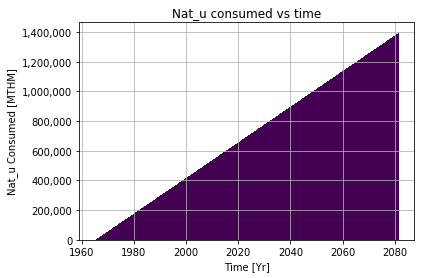

In [15]:
an.stacked_bar_chart(consumption, timestep,
                     'Time [Yr]', 'Nat_u Consumed [MTHM]',
                     'Nat_u consumed vs time',
                     'analysis/results/europe/Nat_u consumption',
                     ini_yr)

Image(filename = 'analysis/results/europe/Nat_u consumption.png')

As shown in the figure above, the mass of natural uranium consumed over the period of the simulation linearly increases. This indicates that the enrichment facility enriches fuel at a constant rate throughout the simulation, regardless of the demand for fresh fuel. This will hopefully be improved in the future so that the enrichment facilities also take the demand for fresh fuel into account.

__Amount of fuel into reactors vs. time__

A more accurate analysis for fuel consumption would be the amount of fuel sent to reactors over time. While the enrichment facility constantly produces fresh fuel, the total amount of fuel sent to reactors change based on the number and size of the reactors in operation at each timestep. This is performed with the `fuel_into_reactors` function, which makes an sqlite query to the `resources`, `transactions`, and `agententry` table to obtain the amount of each fuel sent to reactors throughout the simulation. The resulting data is sent to `get_timeseries_cum` function to obtain the timeseries list of different fuels sent to reactors throughout the simulation.

/home/gyutae/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


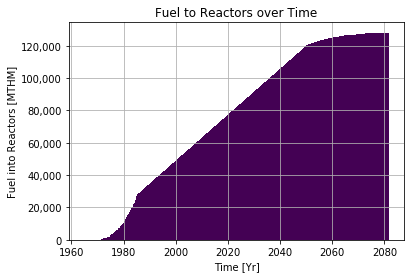

In [16]:
def fuel_into_reactors(cur):
    """ Finds timeseries of mass of fuel received by reactors

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    -------
    timeseries list of fuel into reactors [tons]
    """
    init_year, init_month, duration, timestep = get_timesteps(cur)
    fuel = cur.execute('SELECT time, sum(quantity) FROM transactions '
                       'INNER JOIN resources ON '
                       'resources.resourceid = transactions.resourceid '
                       'INNER JOIN agententry ON '
                       'transactions.receiverid = agententry.agentid '
                       'WHERE spec LIKE "%Reactor%" '
                       'GROUP BY time').fetchall()

    return get_timeseries_cum(fuel, duration, True)


to_reactor = {'Fuel_to_reactor': fuel_into_reactors(cursor)}
an.stacked_bar_chart(to_reactor, timestep,
                     'Time [Yr]', 'Fuel into Reactors [MTHM]',
                     'Fuel to Reactors over Time',
                     'analysis/results/europe/Fuel to Reactors over Time', 
                     ini_yr)

Image(filename = 'analysis/results/europe/Fuel to Reactors over Time.png')

As shown in the figure above, the amount of fuel into reactors over time is not linear and changes with fuel demand by the reactors. This figure reflects the state of the reactor (whether it is operating or refueling), and the number of reactors. From the plot, it can be seen that the number of reactors greatly increased between 1980 and 1990.

__Fuel utilization vs. time__

Fuel utilization factor is the ratio of fuel spent to the amount of natural uranium consumed. While, fuel utilization factor is a value of interest, it is unfortunately, inaccurate at this moment because the enrichment facilities in _CYCLUS_ does not perform demand-driven fuel enrichment. Since the amount of natural uranium consumed is not accurate due to limitations with software, fuel utilization factor, which is a derived variable, will still be inaccurate. However, the functions used to calculate the fuel utilization factor over time will still be displayed for future usage. This is performed with `u_util_calc` function, which runs `nat_u_timeseries` function and `fuel_into_reactors` function to obtain the timeseries lists of natural uranium consumed and the amount of fuel consumed. Then, and element-wise division of the two lists were performed to obtain the fuel utilization factor.

The Average Fuel Utilization Factor is: 
0.100007640845


/home/gyutae/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


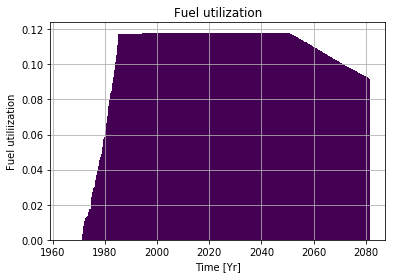

In [17]:
def u_util_calc(cur):
    """ Returns fuel utilization factor of fuel cycle

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    -------
    u_util_timeseries: numpy array
        Timeseries of Uranium utilization factor
    Prints simulation average Uranium Utilization
    """
    # timeseries of natural uranium
    u_supply_timeseries = np.array(nat_u_timeseries(cur))

    # timeseries of fuel into reactors
    fuel_timeseries = np.array(fuel_into_reactors(cur))

    # timeseries of Uranium utilization
    u_util_timeseries = np.nan_to_num(fuel_timeseries / u_supply_timeseries)
    print('The Average Fuel Utilization Factor is: ')
    print(sum(u_util_timeseries) / len(u_util_timeseries))

    return u_util_timeseries


fuel_util = {'Fuel Utilization Factor': u_util_calc(cursor)}
an.stacked_bar_chart(fuel_util, timestep,
                     'Time [Yr]', 'Fuel utiliization',
                     'Fuel utilization',
                     'analysis/results/europe/Fuel utilization', 
                     ini_yr)

Image(filename = 'analysis/results/europe/Fuel utilization.png')

__Capacity vs. time__

Total capacity over time is obtained using `get_power_dict` function and `capacity_calc` function. The `get_power_dict` function performs four sqlite queries to obtain the following: simulation start date, timesteps, institutions declared in _CYCLUS_, and reactors entry and exit timesteps. The results are sent to `capacity_calc` function, which calculates the timeseries value of the total capacity of the reactors in each institution.

FuelCycle has no values


/home/gyutae/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


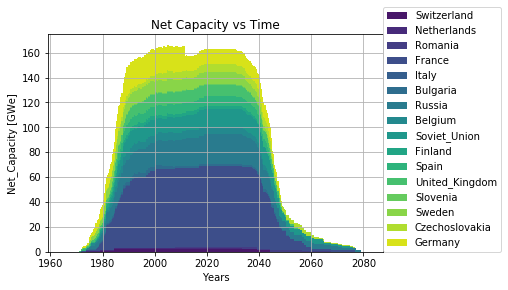

In [18]:
def get_power_dict(cur):
    """ Gets dictionary of power capacity by calling capacity_calc

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    ------
    power_dict: dictionary
        "dictionary with key=government, and
        value=timeseries list of installed capacity"
    """
    init_year, init_month, duration, timestep = get_timesteps(cur)
    governments = get_inst(cur)

    # get power cap values
    entry = cur.execute('SELECT max(value), timeseriespower.agentid, '
                        'parentid, entertime FROM agententry '
                        'INNER JOIN timeseriespower '
                        'ON agententry.agentid = timeseriespower.agentid '
                        'GROUP BY timeseriespower.agentid').fetchall()

    exit_step = cur.execute('SELECT max(value), timeseriespower.agentid, '
                            'parentid, exittime FROM agentexit '
                            'INNER JOIN timeseriespower '
                            'ON agentexit.agentid = timeseriespower.agentid'
                            ' INNER JOIN agententry '
                            'ON agentexit.agentid = agententry.agentid '
                            'GROUP BY timeseriespower.agentid').fetchall()

    return capacity_calc(governments, timestep, entry, exit_step)


def get_inst(cur):
    """ Returns prototype and agentids of institutions

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    -------
    sqlite query result (list of tuples)
    """
    return cur.execute('SELECT prototype, agentid FROM agententry '
                       'WHERE kind = "Inst"').fetchall()


def capacity_calc(governments, timestep, entry, exit_step):
    """Adds and subtracts capacity over time for plotting

    Parameters
    ----------
    governments: list
        list of governments (countries)
    timestep: np.linspace
        list of timestep from 0 to simulation time
    entry: list
        power_cap, agentid, parentid, entertime
        of all entered reactors
    exit_step: list
        power_cap, agentid, parenitd, exittime
        of all decommissioned reactors

    Returns
    -------
    power_dict: dictionary
        "dictionary with key=government, and
        value=timeseries list capacity"
    """
    power_dict = collections.OrderedDict()
    for gov in governments:
        capacity = []
        cap = 0
        for t in timestep:
            for enter in entry:
                if (enter['entertime'] == t and
                        enter['parentid'] == gov['agentid']):
                    cap += enter['max(value)'] * 0.001
            for dec in exit_step:
                if (dec['exittime'] == t and
                        dec['parentid'] == gov['agentid']):
                    cap -= dec['max(value)'] * 0.001
            capacity.append(cap)
        power_dict[gov['prototype']] = np.asarray(capacity)

    return power_dict


capacity_dict = get_power_dict(cursor)

an.stacked_bar_chart(capacity_dict, timestep,
                     'Years', 'Net_Capacity [GWe]',
                     'Net Capacity vs Time',
                     'analysis/results/europe/Capacity vs Time', 
                     ini_yr)
  
Image(filename = 'analysis/results/europe/Capacity vs Time.png')

As shown in the figure above, the net capacity greatly increases between 1965 and 1990. The increase in capacity reflects the increase in the number of reactors in operation. Then, the capacity decreases gradually from around 1995 with a sharp decrease in 2010. This decrease in capacity is due to the Fukushima accident and the consequent shutdown of reactors from nations such as Germany. This trend is also shown in the figure of number of reactors over time below.

__Number of reactors vs time__

A very similar procedure is used to obtain the number of reactors over time. The same four queries made to calculate capacity over time were made to get the number of reactors over time. Then, this is passed to `reactor_deployments` functions, which uses a counter to keep track of the number of reactors operating over time. 

FuelCycle has no values


/home/gyutae/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


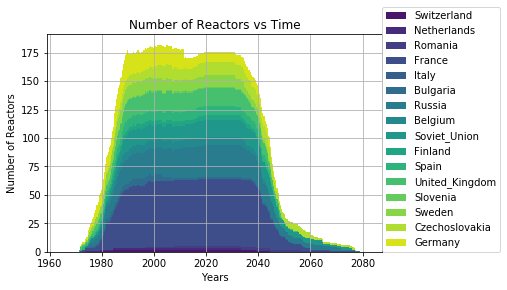

In [19]:
def get_deployment_dict(cur):
    """ Gets dictionary of reactors deployed over time
    by calling reactor_deployments

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    ------
    num_dict: dictionary
        "dictionary with key=government, and
        value=timeseries list of number of reactors"
    """
    init_year, init_month, duration, timestep = get_timesteps(cur)
    governments = get_inst(cur)

    # get power cap values
    entry = cur.execute('SELECT max(value), timeseriespower.agentid, '
                        'parentid, entertime FROM agententry '
                        'INNER JOIN timeseriespower '
                        'ON agententry.agentid = timeseriespower.agentid '
                        'GROUP BY timeseriespower.agentid').fetchall()

    exit_step = cur.execute('SELECT max(value), timeseriespower.agentid, '
                            'parentid, exittime FROM agentexit '
                            'INNER JOIN timeseriespower '
                            'ON agentexit.agentid = timeseriespower.agentid'
                            ' INNER JOIN agententry '
                            'ON agentexit.agentid = agententry.agentid '
                            'GROUP BY timeseriespower.agentid').fetchall()
    
    return reactor_deployments(governments, timestep, entry, exit_step)


def reactor_deployments(governments, timestep, entry, exit_step):
    """Adds and subtracts number of reactors deployed over time
    for plotting

    Parameters
    ----------
    governments: list
        list of governments (countries)
    timestep: np.linspace
        list of timestep from 0 to simulation time
    entry: list
        power_cap, agentid, parentid, entertime
        of all entered reactors

    exit_step: list
        power_cap, agentid, parenitd, exittime
        of all decommissioned reactors

    Returns
    -------
    deployment: dictionary
        "dictionary with key=government, and
        value=timeseries number of reactors"
    """
    deployment = collections.OrderedDict()
    for gov in governments:
        num_reactors = []
        count = 0
        for t in timestep:
            for enter in entry:
                if (enter['entertime'] == t and
                        enter['parentid'] == gov['agentid']):
                    count += 1
            for dec in exit_step:
                if (dec['exittime'] == t and
                        dec['parentid'] == gov['agentid']):
                    count -= 1
            num_reactors.append(count)
        deployment[gov['prototype']] = np.asarray(num_reactors)

    return deployment


an.stacked_bar_chart(get_deployment_dict(cursor), 
                     timestep, 'Years', 
                     'Number of Reactors',
                     'Number of Reactors vs Time',
                     'analysis/results/europe/Number of Reactors vs Time', 
                     ini_yr)

Image(filename = 'analysis/results/europe/Number of Reactors vs Time.png')

## Conclusion

To conclude, _CYCLUS_ has been able to perform simulations at a fairly accurate level as shown in the comparison of the power generation plots. Still, some improvements in _CYCLUS_ would be beneficial: the implementation of an enrichment facility that processes fuel on a need basis. There are other improvements that can be potentially made for this simulation to improve its accuracy.

+  Specify actual burnup for reactors
    + Currently, the reactors deployed in Cyclus are all deployed with a burnup of 51 GWd/MTHM. 
    
    
+  Specify reactor number of batch
    + Reactors were deployed in Cyclus without the actual number fuel batches. The typical values were used for each reactor type (Source needs to be added for the typical values) and for reactors types with missing data, the PWR data was used. While the effects of changing these values may not be significant in the outcome of the simulation, specifying such information may benefit the accuracy of the simulation results.
    
    
+  Apply a similar analysis to different regions such as Asia or in the world
